In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import os

In [ ]:
from keras.optimizers import Adam
from keras.layers import Dense
from keras.models import Sequential
from collections import deque

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Mean % Score =  0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Eval Mean % Score =  0.0


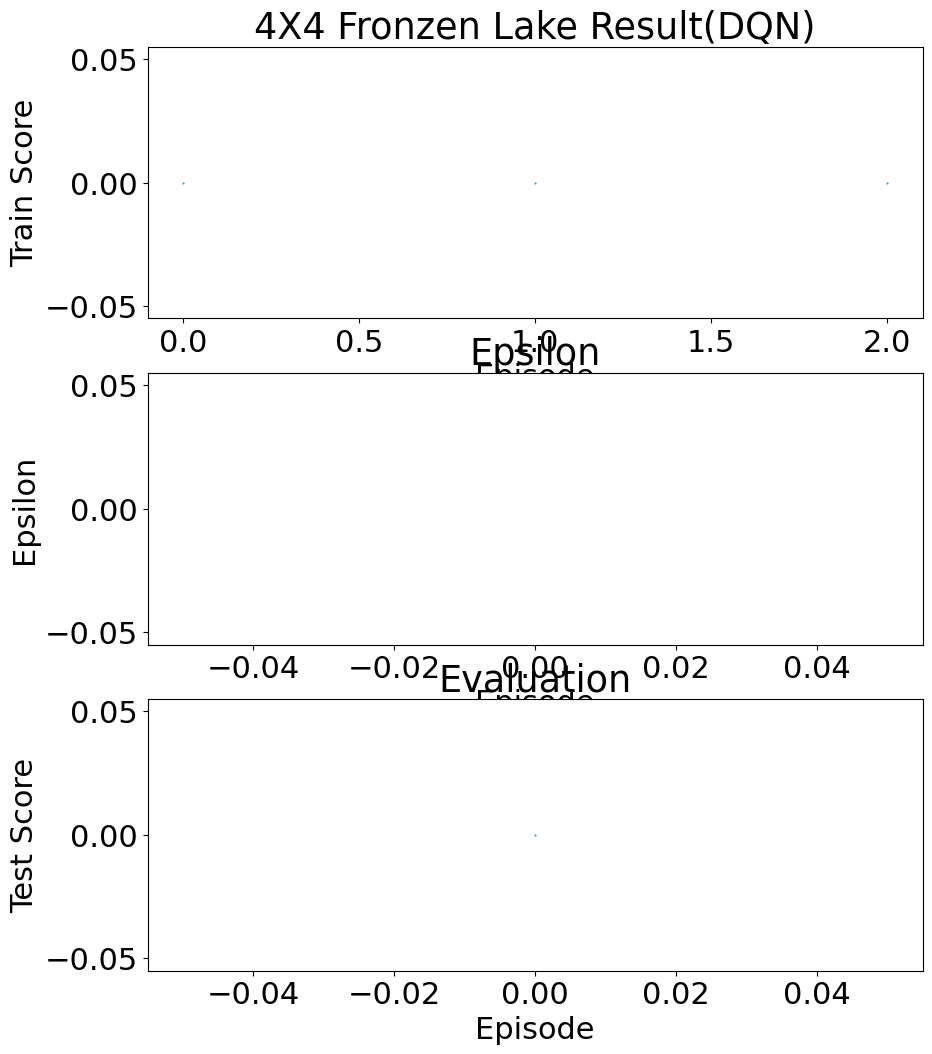

In [4]:
cust_map = [
    'FFFF',
    'FHFH',
    'HFFF',
    'HFFG',
]

env = gym.make("FrozenLake-v1", desc=cust_map, is_slippery=False)
episodes = 3
test = 1
max_steps = 3
state_size = env.observation_space.n
action_size = env.action_space.n
batch_size=32

class DQN:
    def __init__(self, state_size, action_size):
        self.memory = deque(maxlen=2500)
        self.learning_rate = 0.001
        self.epsilon = 1
        self.max_eps=1 # Maximum Epsilon Value
        self.min_eps = 0.01 # Minimum Epsilon Value
        self.eps_decay = 0.0003
        self.gamma = 0.9
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon_lst = []
        self.model = self.built_model_dqn()

    def built_model_dqn(self):
        model = Sequential()
        model.add(Dense(10, input_dim=self.state_size, activation='relu'))
        model.add(Dense(10, input_dim=self.state_size, activation='relu')) # Here, Keras will ignore input_dim and instead take last layer's out put as input
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate = self.learning_rate))
        return model

    def remember(self, new_state, reward, done, state, action):
        self.memory.append((new_state, reward, done, state, action))

    def action(self, state):
        if np.random.rand() > self.epsilon:
            return np.random.randint(0,4)
        return np.argmax(self.model.predict(state))

    def pred(self, state):
        return np.argmax(self.model.predict(state))

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for new_state, reward, done, state, action in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma*np.amax(self.model.predict(state))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.min_eps:
            self.epsilon = (self.max_eps-self.min_eps) * np.exp(-self.eps_decay*episode) + self.min_eps
        self.epsilon_lst.append(self.epsilon)

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

agent_ = DQN(state_size, action_size)
reward_lst = []
for episode in range(episodes):
    state = env.reset()
    state_arr = np.zeros(state_size)
    state_arr[state] = 1
    state = np.reshape(state_arr, [1, state_size])
    reward = 0
    done = False
    for i in range(max_steps):
        #env.render()
        action = agent_.action(state)
        new_state, reward, done, info = env.step(action)
        new_state_arr = np.zeros(state_size)
        new_state_arr[new_state] = 1
        new_state = np.reshape(new_state_arr, [1, state_size])
        agent_.remember(new_state, reward, done, state, action)
        state = new_state

        if done:
            print(f"Episode: {episode:4}/{episodes} and step: {i:4}. Eps:{float(agent_.epsilon):.2}, reward {reward}")
            break
    reward_lst.append(reward)

    if len(agent_.memory) > batch_size:
        agent_.replay(batch_size)

print('Mean % Score = ', round(100*np.mean(reward_lst),1))

#Evaluation

eval_reward_lst = []
for episode in range(test):
    state = env.reset()
    state_arr = np.zeros(state_size)
    state_arr[state] = 1
    state = np.reshape(state_arr, [1, state_size])
    reward = 0
    done = False
    state_lst = []
    state_lst.append(state)
    for j in range(max_steps):
        #env.render()
        action = agent_.pred(state)
        new_state, reward, done, info = env.step(action)
        new_state_arr = np.zeros(state_size)
        new_state_arr[new_state] = 1
        new_state = np.reshape(new_state_arr, [1, state_size])
        state = new_state
        state_lst.append(state)

        if done:
            print(reward)
            break
    eval_reward_lst.append(reward)
print('Eval Mean % Score = ', round(100*np.mean(eval_reward_lst),1))


fig = plt.figure(figsize = (10, 12))
plt.rcParams.clear()
plt.rcParams.update({'font.size': 22})
plt.subplot(311)
plt.scatter(list(range(len(reward_lst))), reward_lst, s=0.2)
plt.title("4X4 Fronzen Lake Result(DQN)")
plt.ylabel('Train Score')
plt.xlabel('Episode')

plt.subplot(312)
plt.scatter(list(range(len(agent_.epsilon_lst))), agent_.epsilon_lst, s=0.2)
plt.title("Epsilon")
plt.ylabel('Epsilon')
plt.xlabel('Episode')

plt.subplot(313)
plt.scatter(list(range(len(eval_reward_lst))), eval_reward_lst, s=0.2)
plt.title("Evaluation")
plt.ylabel('Test Score')
plt.xlabel('Episode')
plt.show()